Data download from: https://www.kaggle.com/datasets/mehradaria/leukemia
Important: Install the conda environment by running the following at your commandline before running the following code:
```
conda env create -f deeplearning.yaml
conda activate deeplearning
```

# Notes on lecture

DP networks determine the importance of combination of features through iterations. Features are transformed, not interpretable
and can be akin to components on a PCA analysis.  
What is a neuron in DP? Just a mathematical function the simplest is similar to a linear function that gets constantly updated.  
It learns through forward (calculates outputs based on inputs and weights) or backpropagation (adjust weights based on the error in the output, or loss, reducing error through iterations).
CNN a type of NN designed for image processing uses convolutional layers to detect spatial features and hierarchies in data.
The image goes through a processing called convolution where kernels transform the matrix enhancing features.
Kernels are matrix which can be used to transform the input matrix and are mathematical operator. with padding and stride they avoid information loss.
Next the kernels transformed matrix or feature maps are further transformed by pooling which can keep maximum features, average, min etc.
This output pooled feature can undergo further convolutions. Pooling is useful to reduce computational costs.
Then loss, often calculated as Mean squared error (MSE) tells us how far the output is from the expect outputs. is based on mathematical distance.  
Then ReLU function makes all negative values as 0, and this is helpful to solve non linear problems.
Softmax all probabilities add up to 1.  
Optimiser a method to alter weights and biases to reduce loss.

Transformers have self-attention so you also have positional encoding


### Load necessary libraries

- torch: (PyTorch) for deep learning functions
- glob: for getting file lists matching patterns
- re: for using regular expressions
- random: for random number generation (setting seed)
- PIL: (pillow) for reading and writing images
- cv2: (OpenCV) for reading and writing images, image analysis
- numpy: for manipulating, reading, and writing arrays
- matplotlib: for plotting

In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, transforms
import re
import random
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
random.seed(123)
torch.manual_seed(123)

In [2]:
# Identifying script folder
cwd = os.getcwd()

# Defining work directory
wd = os.path.dirname(cwd)

# Defining data directory
data_dir = os.path.join(wd, 'Data/DP')

os.chdir(data_dir)

data_dir

'/Users/kgurashi/Desktop/training_ml/ML_DP_Training/Data/DP'

### Introduction to image data

Pillow loads image in RGB format, but PIL objects have to be converted to numpy arrays for further downstream processing.

<class 'PIL.JpegImagePlugin.JpegImageFile'>


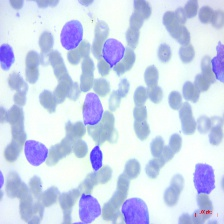

In [3]:
# Loading images with pillow
img_file = "Early/WBC-Malignant-Early-003.jpg"
img_pil = Image.open(img_file)
print(type(img_pil))
img_pil

OpenCV loads the image in BGR format, so it needs to be converted to RGB format for visualisation. On the plus side, the data is already a numpy array.

<class 'numpy.ndarray'>


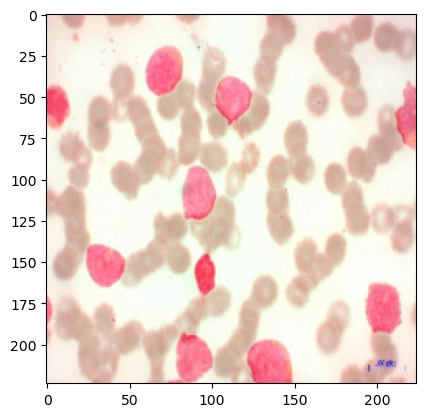

In [4]:
# Loading images with OpenCV
img_cv = cv2.imread(img_file)
print(type(img_cv))
plt.imshow(img_cv)

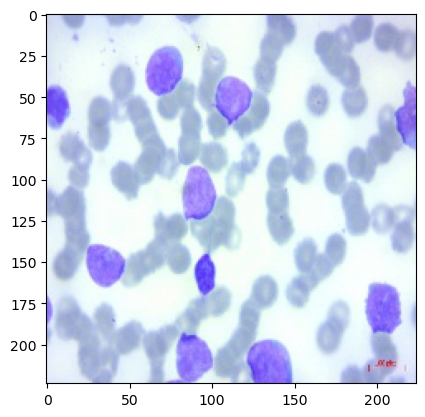

In [5]:
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv)

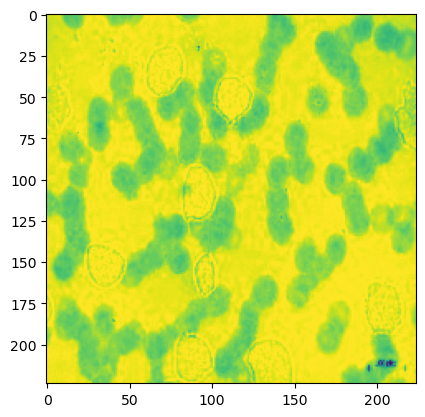

In [6]:
plt.imshow(img_cv[:, :, 2])

### Building the dataset

In [7]:
class DatasetBuilder(Dataset):
    # A class to read files from a folder, and perform necessary transformations
    # Also, the class labels are obtained from the filename
    # Also look at torchvision.transforms
    def __init__(self, folder, size=128):
        files = glob.glob(f"{folder}/*.jpg")
        # read images
        self.images = [Image.open(x) for x in files]

        # resize images
        self.images = [x.resize((size, size), Image.Resampling.LANCZOS)  for x in self.images]

        # convert to images to numpy arrays
        self.images = [np.asarray(x) for x in self.images]

        # normalize images - try with and without normalisation
        self.images = [((x/255.0)-0.5)/0.5 for x in self.images]
        
        # get labels from filenames (files contain the labels in their names e.g. WBC-Malignant-Early-003.jpg)
        self.labels = [re.sub('.*/(.*)-(\\d+).jpg', '\\1', x) for x in files]
        self.classes_dict = dict((key, val) for val, key in enumerate(set(self.labels)))
        self.labels = [self.classes_dict[x] for x in self.labels]
        print(f"{len(self.images)} files, {len(self.labels)} labels, {len(self.classes_dict)} classes")


    def __getitem__(self, i): #numpy array to tensor (like arrays but they also store calculations as an additional slot or layer)
        return torch.tensor(self.images[i].astype(np.float32)).permute(2, 0, 1), torch.tensor(self.labels[i])

    def __len__(self):
        return len(self.images)

    def classes(self):
        return self.classes_dict



In [8]:
# Create dataset instance
datasetfromfiles = DatasetBuilder("**")
dataclasses = datasetfromfiles.classes()

3256 files, 3256 labels, 4 classes


In [9]:
dataclasses

{'WBC-Benign': 0,
 'WBC-Malignant-Pre': 1,
 'WBC-Malignant-Early': 2,
 'WBC-Malignant-Pro': 3}

### Preparation for training

In [10]:
# Set batch size
batch_size = 32

# Split datasets
train_set, val_set, test_set = random_split(datasetfromfiles, [0.7, 0.15, 0.15])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43529412..1.0].


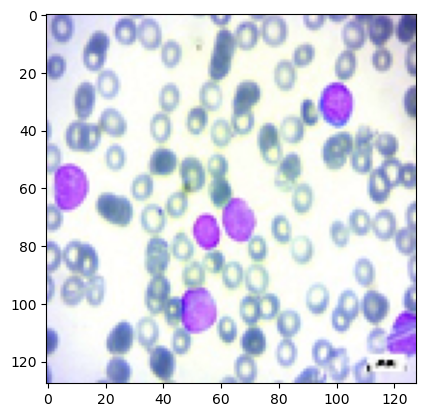

In [11]:
# Get a batch of training images
data_iter = iter(train_loader)

# Show an image to check
plt.imshow(next(data_iter)[0][0].permute(1, 2, 0))

In [12]:
next(data_iter)[0].shape

torch.Size([32, 3, 128, 128])

### What is a convolution

In [13]:
class SimpleConvModel(nn.Module):
    def __init__(self):
        super(SimpleConvModel, self).__init__()
        
        # Define a single convolution layer with 1 input channel and 1 output channel
        # kernel_size=3 applies a 3x3 filter, and stride=1 with padding=1 keeps the output size the same
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
        
        # Initialize the kernel (filter) manually to see specific behavior (edge detection)
        edge_kernel = torch.tensor([[[[-1, -1, -1],
                                      [-1,  8, -1],
                                      [-1, -1, -1]]]], dtype=torch.float32)
        edge_kernel = edge_kernel.repeat(1, 3, 1, 1)
        
        self.conv.weight = nn.Parameter(edge_kernel)

    def forward(self, x):
        x = self.conv(x)
        return x


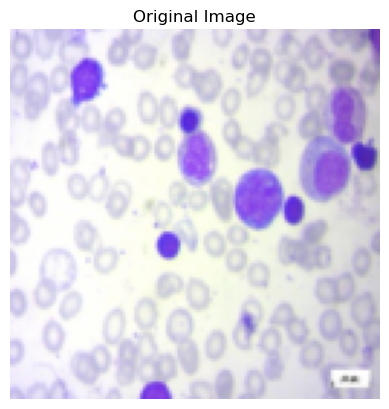

In [16]:
# Load a grayscale image and apply transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize for easier visualization
    transforms.ToTensor()             # Convert image to tensor [1, H, W]
])

image = Image.open("Benign/WBC-Benign-004.jpg")
image = transform(image).unsqueeze(0)  # Add batch dimension to shape [1, 1, H, W]

# Plot the original image
plt.imshow(image.squeeze().permute(1, 2, 0))#, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()


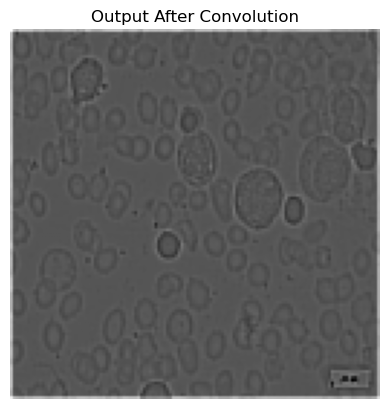

In [17]:
# Initialize the model and move it to evaluation mode
model = SimpleConvModel()
model.eval()

# Apply the model to the image
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image)

# Convert output tensor to numpy for plotting
output_image = output.squeeze().numpy()

# Plot the output after convolution
plt.imshow(output_image, cmap="gray")
plt.title("Output After Convolution")
plt.axis("off")
plt.show()


In SimpleConvModel, try changing the edge kernel to the following:
```
edge_kernel = torch.tensor([[[[1, 1, 1],
                              [0, 0, 0],
                              [-1, -1, -1]]]], dtype=torch.float32)

```

### Now to build a Convolutional Neural Network model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling layer

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust dimensions based on image size after convolutions
        self.fc2 = nn.Linear(128, num_classes)    # Output layer for the number of classes - convert the levels into the number of classes we have, each level is represented as a value 0 to 1

    def forward(self, x):
        # Pass through first convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Pass through second convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Pass through third convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 16 * 16)  # Flattening - this convert the stack of images into one long vector, then the 128 to 0 to 3 so the predictions

        # Pass through first fully connected layer
        x = F.relu(self.fc1(x))
        
        # Output layer (no activation, as we'll apply CrossEntropyLoss during training)
        x = self.fc2(x)
        
        return x

In [19]:
# Define the number of classes based on our dataset
num_classes = len(dataclasses) 

# Initialize the model
model = SimpleCNN(num_classes=num_classes)


In [24]:
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:

# Define the loss function
criterion = nn.CrossEntropyLoss() # Another type of loss function

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) #lr is learning rate here. You don't want it to be too high otherwise it will change weights and biases too much for each iteration. 
#But also if too low then it will arrive at the solution too slowly. The concept is similar to gradient descent. E.g. Evaluate your gps location on the direction to somewhere after N steps. Too many steps and you may be off, too few and it will take forever to get there. 


In [ ]:
# training loop
num_epochs = 10  # Set number of epochs for training; change this number to see how model works

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:  
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step() #Here updates weights and biases and it is applied to the next batch of images
        
        # Print statistics
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")
# If the rate of decrease of the loss pleateus then you want to stop training otherwise it will overfit and not be generalizable to new data.

Epoch [1/9], Loss: 0.0426
Epoch [2/9], Loss: 0.0255
Epoch [3/9], Loss: 0.0184
Epoch [4/9], Loss: 0.0147
Epoch [5/9], Loss: 0.0128
Epoch [6/9], Loss: 0.0091
Epoch [7/9], Loss: 0.0041
Epoch [8/9], Loss: 0.0028
Epoch [9/9], Loss: 0.0020
Training complete!


In [27]:
# Weights and biases can be extracted and saved for future use
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.4604e-01,  4.9989e-02, -1.7855e-01],
                        [-5.0150e-02,  2.1811e-02,  1.2649e-02],
                        [ 2.1663e-01, -2.3374e-02, -2.4662e-02]],
              
                       [[-3.9924e-02,  1.4606e-01, -2.1191e-01],
                        [ 1.3737e-01, -1.2977e-01, -5.5897e-02],
                        [ 5.5295e-02,  1.5356e-01, -7.9448e-02]],
              
                       [[ 3.8748e-03,  3.2966e-02,  1.4393e-01],
                        [-8.8624e-02, -8.9627e-03, -1.5033e-01],
                        [ 1.4048e-01, -1.5437e-01, -1.5981e-02]]],
              
              
                      [[[ 2.6356e-02, -3.6907e-02,  1.4581e-01],
                        [-1.0122e-01,  1.6681e-01,  8.7267e-02],
                        [ 6.6288e-02,  5.8912e-02,  1.3997e-02]],
              
                       [[-4.7433e-02, -1.8280e-01, -2.3503e-01],
                        [ 1.2187e-01,  4.4656

In [28]:
# Model evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 91.39%


### Exercise
- Exercise - try adding conv layers and see the effect on model performance
- Hyperparameter tuning - learning rate

### Using pre-trained models (e.g. ResNet18)

In [29]:
from torchvision.models import resnet18, ResNet18_Weights

In [30]:
from torchvision.io import decode_image, read_image

In [31]:
# Initialize model with the available weights
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kgurashi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in train_loader:  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# This doesnt work because it is trained expect 1000 classes not ours so we have to remove this final layer and replace it with our own final layer

Validation Accuracy: 0.00%


### Why is the accuracy zero?
Let's look at one image

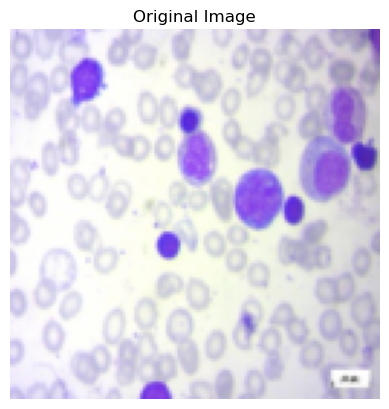

In [33]:
# Load an image and apply transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize for easier visualization
    transforms.ToTensor()             # Convert image to tensor [1, H, W]
])

image = Image.open("Benign/WBC-Benign-004.jpg")
image = transform(image).unsqueeze(0)  # Add batch dimension to shape [1, 1, H, W]

# Plot the original image
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title("Original Image")
plt.axis("off")
plt.show()

In [34]:
# Initialize the ResNet model and move it to evaluation mode
model.eval()

# Apply the model to the image
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image)
    _, predicted = torch.max(output, 1)
print(predicted.item())

import urllib.request
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_labels = urllib.request.urlopen(url).read().decode().splitlines()

class_labels[predicted.item()]

794


'shower curtain'

### Re-training a model - using the same weights, but assigning different classes

In [35]:
# Create dataset instance
datasetfromfiles = DatasetBuilder("**", size=224)
dataclasses = datasetfromfiles.classes()
dataclasses

3256 files, 3256 labels, 4 classes


{'WBC-Benign': 0,
 'WBC-Malignant-Pre': 1,
 'WBC-Malignant-Early': 2,
 'WBC-Malignant-Pro': 3}

In [ ]:
# Freeze all layers except the final layer (optional, for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with a new one
num_classes = len(dataclasses)  # Number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes) # Here we are removing the final layer and replacing it with our own layer with the number of classes we have
# We only retrain this final step where the learned features are mapped to our specific classes


In [37]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer, only updating the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [38]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move data to device if using GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')
        model.train()  # Set model back to training mode after validation

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5, Loss: 0.7089485277732214
Validation Accuracy: 91.39%
Epoch 2/5, Loss: 0.29411316404326093
Validation Accuracy: 93.44%
Epoch 3/5, Loss: 0.22163255730022988
Validation Accuracy: 94.88%
Epoch 4/5, Loss: 0.20011134828544325
Validation Accuracy: 95.49%
Epoch 5/5, Loss: 0.16256405563197202
Validation Accuracy: 96.52%


In [39]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 92.83%


In [40]:
dataclasses

{'WBC-Benign': 0,
 'WBC-Malignant-Pre': 1,
 'WBC-Malignant-Early': 2,
 'WBC-Malignant-Pro': 3}

In [41]:
# Initialize the ResNet model and move it to evaluation mode
model.eval()

# Apply the model to the image
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image)
    _, predicted = torch.max(output, 1)
print(predicted.item())

class_labels = {v: k for k,v in dataclasses.items()}

class_labels[predicted.item()]

0


'WBC-Benign'